# Exploration of IFS-AMIP data

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import intake

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean.cm as cmo
import seaborn as sns

from datetime import datetime

from dask.diagnostics import ProgressBar

In [2]:
cd

/home/b/b382473


In [3]:
import geostats as gs

In [4]:
import iris
import iris.analysis as ia

In [5]:
def ifs_to_latlon(ds):
    '''
    Uses the latitude-longitude information encoded in the regular grid IFS output to reconstructed the regular grid
    '''
    return ds.rename({'value':'latlon'}).set_index(latlon=("lat","lon")).unstack("latlon")
def ifs_fix_time_for_monthly_data(ds):
    '''
    Monthly mean data has the time axis encoded incorrectly.
    This function shifts it back by one day
    '''
    return ds.assign_coords(time=ds['time']- pd.Timedelta('1D'))

def get_area(da,mask=False):
    print('Computing grid-box area')
    import iris.analysis as ia
    if 'time' in da.dims:
        da = da.isel(time=0).drop('time')
    d = da.to_iris()
    d.coord('longitude').guess_bounds()
    d.coord('latitude').guess_bounds()

    area_weights = ia.cartography.area_weights(d)
    area = xr.ones_like(da) * area_weights
    if mask:
        area = area.where(~np.isnan(da))
    area = area.rename('area').load()
    area.attrs['long_name'] = 'grid_box_area'
    area.attrs['units'] = 'm^2'
    return area

def print_var(ds,filt=None):
    '''
    Print variables (varname,name) in Dataset. 
    If <filt> is provided, print only those where <filt> is present in the <name> attribute (ds[shortname].attrs['name'])

    Usage: print_var(ds,'wind')
    Output: printout of variables in ds whose name (long name in attributes, not short name to access) contains 'wind', e.g.
        10si  :   10 metre wind speed
        10u  :   10 metre U wind component
        10v  :   10 metre V wind component
    '''
    if filt:
        [print('%10s  :   %s' % (d,ds[d].attrs['name'])) for d in ds if filt.lower() in ds[d].attrs['name'].lower()]
    else:
        [print('%10s  :   %s' % (d,ds[d].attrs['name'])) for d in ds]

## Open and inspect the catalogue

In [18]:
cat = intake.open_catalog('https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml')\
                          ['dkrz']['disk']['model-output']['ifs-amip']

In [19]:
list(cat)

['amip-hist-obs.atmos.gr025',
 'amip-hist-obs-lr30.atmos.gr025',
 'amip-hist-obs-c-lr30-a-0.atmos.gr025',
 'amip-hist-obs-c-lr30-a-lr30.atmos.gr025',
 'amip-ng-obs.atmos.gr025',
 'amip-ng-obs-lr30.atmos.gr025',
 'amip-hist-esav3.atmos.gr025',
 'amip-hist-esav3-c-0-a-lr30.atmos.gr025']

In [8]:
run = 'amip-hist-obs'

ds_2d_6h_nat = cat[run + '.atmos.gr025']['2D_6h_native'].to_dask()
ds_2d_6h_025 = ifs_to_latlon(cat[run + '.atmos.gr025']['2D_6h_0.25deg'].to_dask())

# Tropical clouds

In [85]:
ds_2d_6h_025

<xarray.Dataset>
Dimensions:  (lat: 721, lon: 1440, time: 4018)
Coordinates:
  * lat      (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * time     (time) datetime64[ns] 2010-01-01T12:00:00 ... 2020-12-31T12:00:00
Data variables: (12/46)
    10u      (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    10v      (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    2d       (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    2t       (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    cape     (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    ci       (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    ...       ...
    tclw     (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    tcwv     (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    tisr     (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    tp       (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    tsr      (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    ttr      (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
Attributes:
    edition:            1
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          0
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

In [99]:
# tt = ifs_to_latlon(cat['amip-hist-obs' + '.atmos.gr025']['2D_6h_0.25deg'].to_dask())[['tclw','tciw']].sel(time='2020-08').sel(lat=slice(-30,30))
tt = ifs_to_latlon(cat['amip-hist-obs' + '.atmos.gr025']['2D_6h_0.25deg'].to_dask())[['tclw','tciw']].sel(time='2020').sel(lat=slice(-30,30))

In [100]:
with ProgressBar():
    tt.load()

[########################################] | 100% Completed | 11.72 s


[]

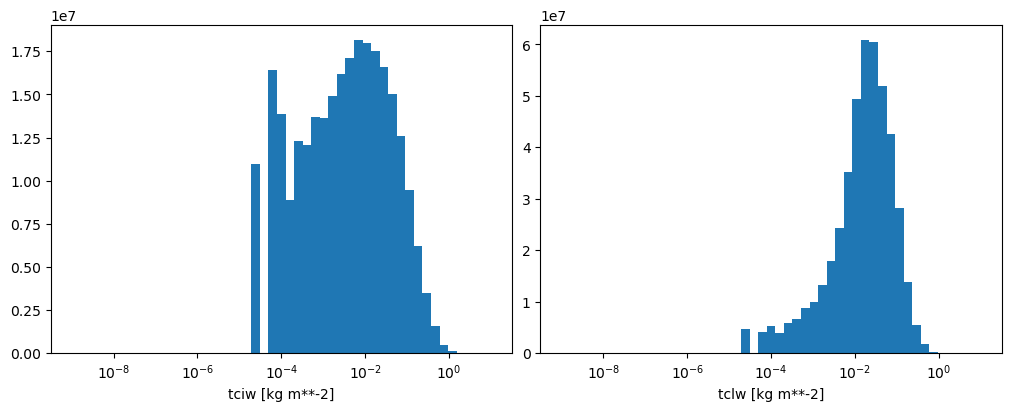

In [101]:
fig, ax = plt.subplots(1,2,sharex=True,constrained_layout=True,figsize=(10,4))
tt['tciw'].plot(bins=np.logspace(-9,1),ax=ax[0])#,density=True)
tt['tclw'].plot(bins=np.logspace(-9,1),ax=ax[1])#,density=True)
plt.semilogx()

In [61]:
cat = intake.open_catalog('https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml')\
                          ['dkrz']['disk']['model-output']['ifs-amip']

In [62]:
list(cat)

['amip-hist-obs.atmos.gr025',
 'amip-hist-obs-lr30.atmos.gr025',
 'amip-hist-obs-c-lr30-a-0.atmos.gr025',
 'amip-hist-obs-c-lr30-a-lr30.atmos.gr025',
 'amip-ng-obs.atmos.gr025',
 'amip-ng-obs-lr30.atmos.gr025',
 'amip-hist-esav3.atmos.gr025',
 'amip-hist-esav3-c-0-a-lr30.atmos.gr025']

In [31]:
run = 'amip-hist-esav3'

# ds_2d_6h_nat2 = cat[run + '.atmos.gr025']['2D_6h_native'].to_dask()
ds_2d_6h_025_2 = ifs_to_latlon(cat[run + '.atmos.gr025']['2D_6h_0.25deg'].to_dask())

In [102]:
# tt2 = ds_2d_6h_025_2[['tclw','tciw']].sel(time='2020-08').sel(lat=slice(-30,30))#.plot.hist(bins=100)
tt2 = ds_2d_6h_025_2[['tclw','tciw']].sel(time='2020').sel(lat=slice(-30,30))#.plot.hist(bins=100)

In [103]:
with ProgressBar():
    tt2.load()

[########################################] | 100% Completed | 11.87 s


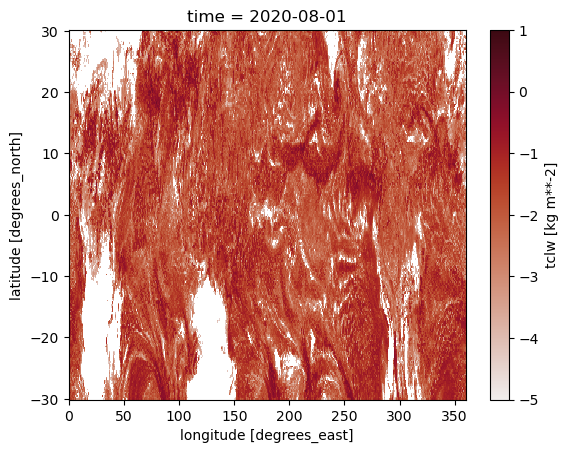

In [93]:
np.log10(tt2.tclw[0]).plot(cmap=cmo.amp,vmin=-5,vmax=1)

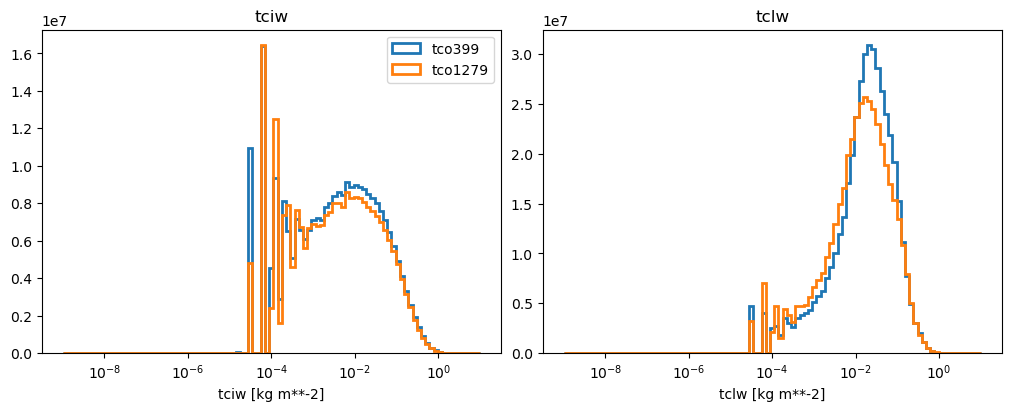

In [104]:
fig, ax = plt.subplots(1,2,sharex=True,constrained_layout=True,figsize=(10,4))
tt['tciw'].plot(bins=np.logspace(-9,1,100),ax=ax[0],histtype='step',lw=2,density=False,color='C0')
tt['tclw'].plot(bins=np.logspace(-9,1,100),ax=ax[1],histtype='step',lw=2,density=False,color='C0')

tt2['tciw'].plot(bins=np.logspace(-9,1,100),ax=ax[0],histtype='step',lw=2,density=False,color='C1')
tt2['tclw'].plot(bins=np.logspace(-9,1,100),ax=ax[1],histtype='step',lw=2,density=False,color='C1')
plt.semilogx()

ax[0].set_title('tciw')
ax[1].set_title('tclw')

ax[0].legend(['tco399','tco1279'])

In [ ]:
fig, ax = plt.subplots(1,2,sharex=True,constrained_layout=True,figsize=(10,4))
tt['tciw'].plot(bins=np.linspace(1e-9,1e1,1000),ax=ax[0],histtype='step',lw=2,density=False,color='C0')
tt['tclw'].plot(bins=np.linspace(1e-9,1e1,1000),ax=ax[1],histtype='step',lw=2,density=False,color='C0')

tt2['tciw'].plot(bins=np.linspace(1e-9,1e1,1000),ax=ax[0],histtype='step',lw=2,density=False,color='C1')
tt2['tclw'].plot(bins=np.linspace(1e-9,1e1,1000),ax=ax[1],histtype='step',lw=2,density=False,color='C1')
plt.semilogx()

ax[0].set_title('tciw')
ax[1].set_title('tclw')

ax[0].legend(['tco399','tco1279'])

In [ ]:
tt2['tclw']

# Tropical SST & precip

In [37]:
from xhistogram.xarray import histogram

In [38]:
histogram

<function xhistogram.xarray.histogram(*args, bins=None, range=None, dim=None, weights=None, density=False, block_size='auto', keep_coords=False, bin_dim_suffix='_bin')>

In [42]:
dsi = ds_2d_6h_025_2[['sst','tp']].sel(
    lat=slice(-30,30)
).sel(
    time='2020-04'
)

In [46]:
dsi.nbytes / 1e9

0.666331208

In [47]:
with ProgressBar():
    dsi.load()

[########################################] | 100% Completed | 1.12 sms


In [77]:
df = pd.DataFrame(
    # index=dsi.sst.values.flatten(),
    data={'sst':dsi.sst.values.flatten(),'tp':dsi.tp.values.flatten()}
).dropna()

In [79]:
import seaborn as sns

<Axes: xlabel='sst', ylabel='tp'>

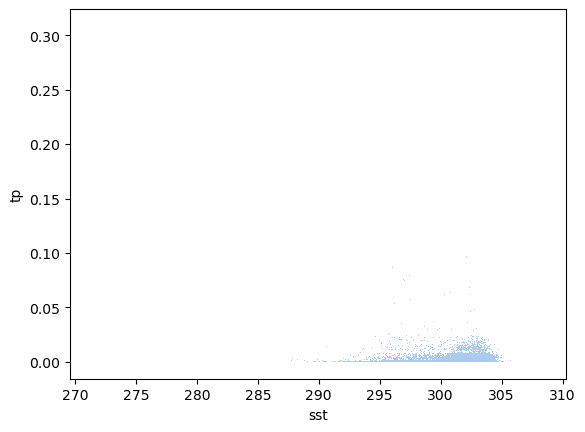

In [80]:
sns.histplot(df,x='sst',y='tp')

In [70]:
dsi.sst

<xarray.DataArray 'sst' (time: 120, lat: 241, lon: 1440)>
array([[[295.80273438, 295.44335938, 295.46679688, ..., 296.20117188,
         296.29785156, 296.34179688],
        [296.17675781, 295.86523438, 295.58007812, ..., 296.08398438,
         296.04199219, 296.13378906],
        [296.05761719, 296.01269531, 295.62792969, ..., 296.04101562,
         296.00878906, 296.00976562],
        ...,
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]],

       [[295.80371094, 295.44238281, 295.46582031, ..., 296.20019531,
         296.296875  , 296.34082031],
        [296.17675781, 295.86425781, 295.57910156, ..., 296.08300781,
         296.04101562, 296.13378906],
        [296.05664062, 296.01269531, 295.62695312, ..., 296.04003906,
         296.00878906, 296.00976562],
...
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]],

       [[294.95800781, 294.71386719, 294.43847656, ..., 295.29882812,
         294.97558594, 295.01660156],
        [295.01074219, 294.90820312, 294.82910156, ..., 295.65917969,
         295.171875  , 295.09863281],
        [295.015625  , 294.95117188, 294.97363281, ..., 295.88183594,
         295.42089844, 295.10449219],
        ...,
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]]])
Coordinates:
  * lat      (lat) float64 -30.0 -29.75 -29.5 -29.25 ... 29.25 29.5 29.75 30.0
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * time     (time) datetime64[ns] 2020-04-01 ... 2020-04-30T18:00:00
Attributes: (12/15)
    paramId:                    34
    dataType:                   fc
    numberOfPoints:             1038240
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    name:                       Sea surface temperature
    cfVarName:                  sst
    missingValue:               3.4028234663852886e+38
    totalNumber:                1
    NV:                         0
    gridDefinitionDescription:  Latitude/Longitude Grid

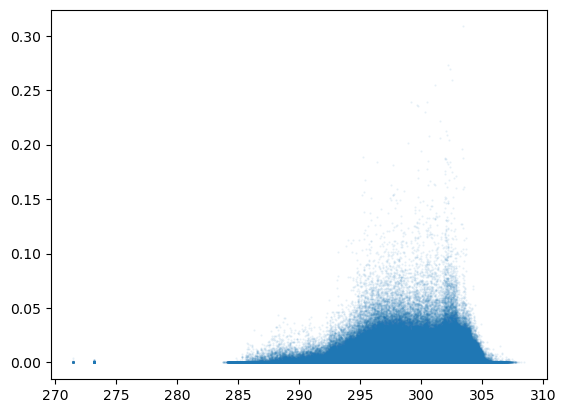

In [69]:
plt.plot(
    dsi.sst.values.flatten(),
    dsi.tp.values.flatten(),
    '.',
    alpha=0.1,
    markersize=1
)

# Precipitation in 9 km IFS-AMIP

In [104]:
tprate_mean_2020_202109 = ifs_to_latlon(
    cat2['amip-hist-esav3.atmos.gr025']['2D_monthly_0.25deg'].to_dask()['tprate']
).mean('time')#[5].max().load()
with ProgressBar():
    tprate_mean_2020_202109.load()

[########################################] | 100% Completed | 309.61 ms


In [171]:
tprate_mean_2020_202109 * 100 * 86400

<xarray.DataArray 'tprate' (lat: 721, lon: 1440)>
array([[2.23614431e-09, 2.23614431e-09, 2.23614431e-09, ...,
        2.23614431e-09, 2.23614431e-09, 2.23614431e-09],
       [1.96589445e-09, 1.96520150e-09, 1.96450856e-09, ...,
        1.97143804e-09, 1.97005214e-09, 1.96589445e-09],
       [2.04350467e-09, 2.04281172e-09, 2.04142582e-09, ...,
        2.04350467e-09, 2.04350467e-09, 2.04350467e-09],
       ...,
       [8.87458944e-09, 8.87666829e-09, 8.87944008e-09, ...,
        8.87458944e-09, 8.87320355e-09, 8.87320355e-09],
       [8.74639400e-09, 8.74500810e-09, 8.74708695e-09, ...,
        8.74847285e-09, 8.74708695e-09, 8.74500810e-09],
       [8.84202087e-09, 8.84202087e-09, 8.84202087e-09, ...,
        8.84202087e-09, 8.84202087e-09, 8.84202087e-09]])
Coordinates:
  * lat      (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8

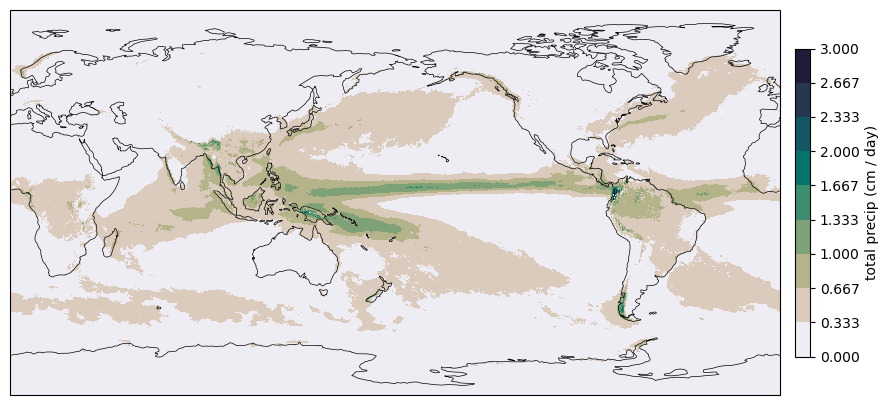

In [204]:
(tprate_mean_2020_202109 * 1000 * 86400 / 10).plot(
    vmax=3,cmap=cmo.rain,levels=10,subplot_kws=dict(projection=ccrs.PlateCarree(central_longitude=180)),transform=ccrs.PlateCarree(),
    cbar_kwargs=dict(shrink=0.8,label='total precip (cm / day)',pad=0.0125),extend='neither',
    figsize=(15,5)
)
plt.gca().coastlines(lw=0.5)

In [119]:
ds_nat = cat2['amip-hist-esav3.atmos.gr025']['2D_6h_native'].to_dask()

/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


In [120]:
tp_nat = ds_nat['tp'].sel(time=slice('2021-09'))

In [169]:
tp_nat_2021_07_2021_09 = tp_nat.sel(time=slice('2021-07','2021-09')).mean('time')
tp_nat_2021_07_2021_09 = tp_nat_2021_07_2021_09 / (6*60*60) * 100 * 86400
tp_nat_2021_07_2021_09.attrs['units'] = 'cm / day'

In [170]:
with ProgressBar():
    tp_nat_2021_07_2021_09.load()

[########################################] | 100% Completed | 34.82 s


In [174]:
tp_nat_2021_07_2021_09.max()

<xarray.DataArray 'tp' ()>
array(6.65610355)

Text(0.5, 1.0, 'Total precipitation, AMIP-IFS, tco1279, 2021-07 - 2021-09')

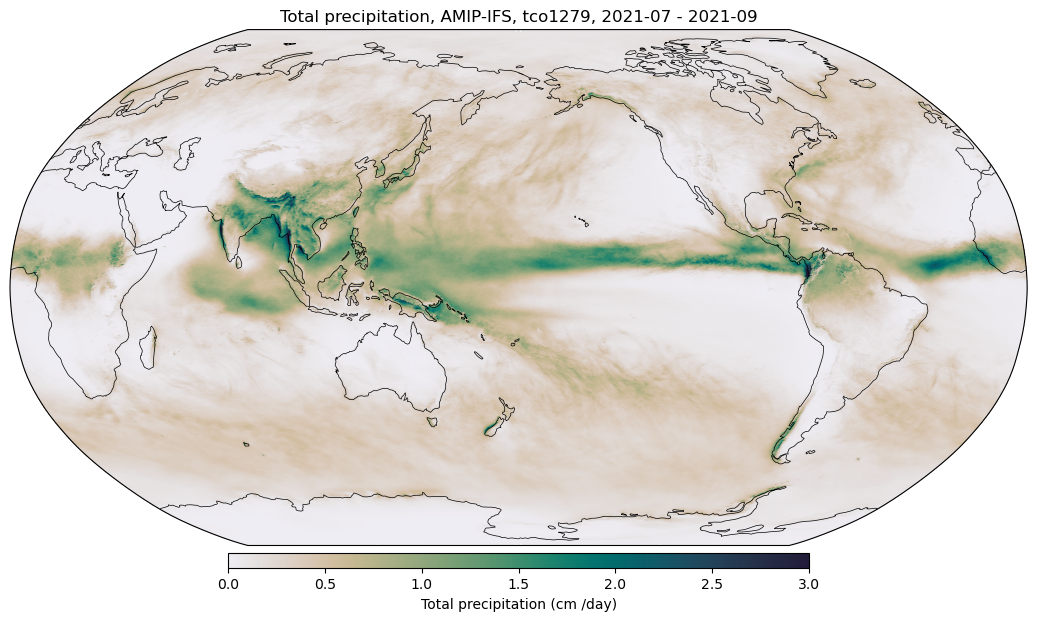

In [200]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.Robinson(central_longitude=180)),figsize=(15,8))
p = gs.scatter_map(
    # tp_nat_2021_07_2021_09[::100],
    tp_nat_2021_07_2021_09,
    s=0.5,
    # s=5,
    ax=ax,
    lat='lat',lon='lon',
    vmax=3,
    cmap=cmo.rain,
    transform=ccrs.PlateCarree(),
    # levels=10
)
cbar = fig.colorbar(p,ax=ax,orientation='horizontal',pad=0.0125,shrink=0.5,aspect=40,label='Total precipitation (cm /day)')
ax.coastlines(lw=0.5)
ax.set_title('Total precipitation, AMIP-IFS, tco1279, 2021-07 - 2021-09')